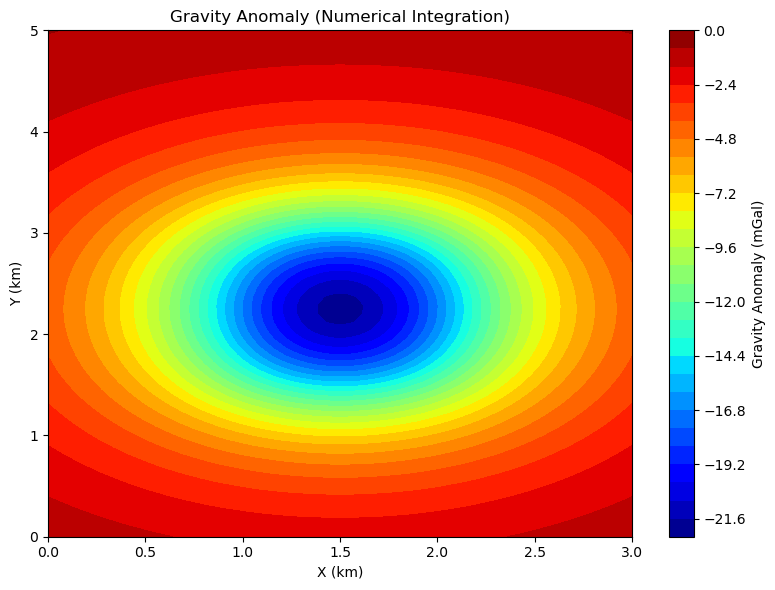

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import verde as vd

# -----------------------------
# Grid setup (voxel model)
dx = dy = dz = 20  # finer voxel resolution
nx, ny, nz = int(3000/dx), int(5000/dy), int(2000/dz)

x = (np.arange(nx) + 0.5) * dx
y = (np.arange(ny) + 0.5) * dy
z = (np.arange(nz) + 0.5) * dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# -----------------------------
# Density model
labels = np.zeros((nx, ny, nz), dtype=int)
density = np.zeros_like(labels, dtype=float)

# Rectangular Prism (same as Harmonica)
rho = 2670
xmin, xmax = 1000, 2000
ymin, ymax = 1500, 3000
zmin, zmax = 500, 1500

mask = (
    (X >= xmin) & (X <= xmax) &
    (Y >= ymin) & (Y <= ymax) &
    (Z >= zmin) & (Z <= zmax)
)
labels[mask] = 1
density[mask] = rho

# -----------------------------
# Observation grid (matched with Harmonica)
region = (0, 3000, 0, 5000)
obs_nx, obs_ny = 60, 100
shape = (obs_nx, obs_ny)

# Use same coordinates as Harmonica (cell centers)
obs_coords = vd.grid_coordinates(region=region, shape=shape, extra_coords=0)
obs_x = obs_coords[0].reshape(shape)
obs_y = obs_coords[1].reshape(shape)
Xobs, Yobs = obs_x, obs_y
Zobs = np.zeros_like(Xobs)

# -----------------------------
# Gravity modeling (numerical integration)
G = 6.67430e-11  # m^3 kg^-1 s^-2
gz = np.zeros_like(Xobs)

# Create 3D voxel center positions
Xc, Yc, Zc = np.meshgrid(x, y, z, indexing='ij')

# Numerical integration over voxel model
for i in range(obs_nx):
    for j in range(obs_ny):
        rx = Xobs[i, j] - Xc
        ry = Yobs[i, j] - Yc
        rz = Zobs[i, j] - Zc
        r2 = rx**2 + ry**2 + rz**2 + 1e-12  # avoid zero division
        gz[i, j] = np.sum(G * density * rz / (r2**1.5) * dx * dy * dz)

# Convert to mGal
gz_mgal = gz * 1e5

# -----------------------------
# Plot gravity anomaly
plt.figure(figsize=(8, 6))
extent = [region[0]/1000, region[1]/1000, region[2]/1000, region[3]/1000]
cp = plt.contourf(Xobs / 1000, Yobs / 1000, gz_mgal, levels=30, cmap='jet')
plt.colorbar(cp, label="Gravity Anomaly (mGal)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("Gravity Anomaly (Numerical Integration)")
plt.tight_layout()
plt.show()


In [2]:
# BY HARMONICA

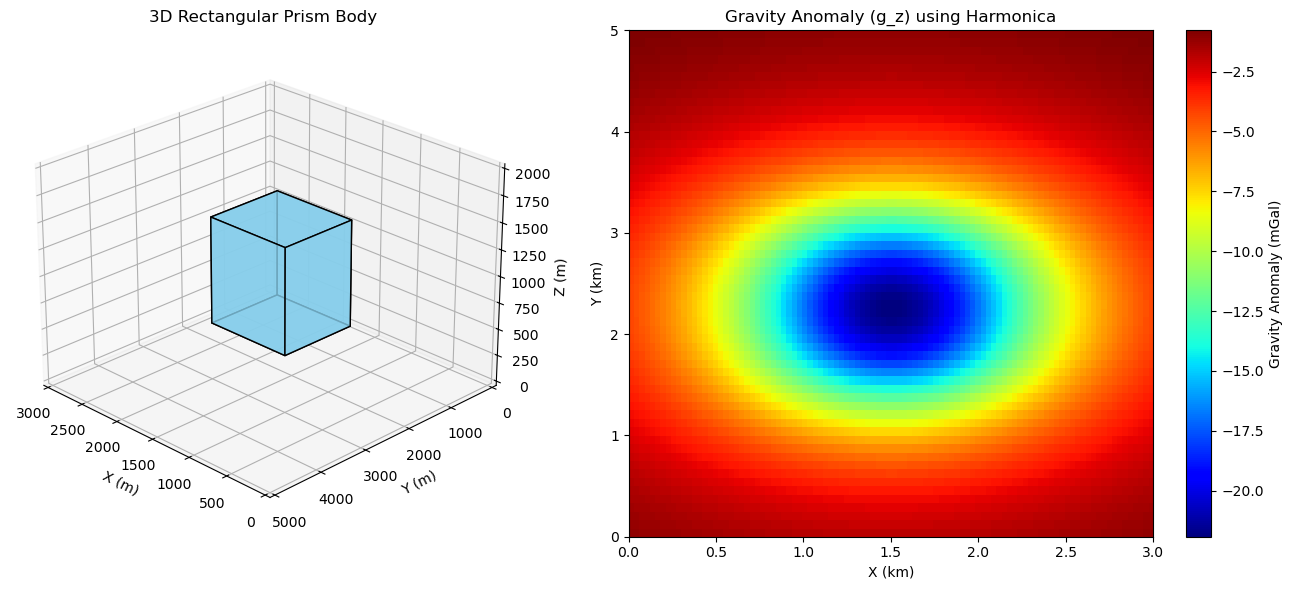

In [17]:

import numpy as np
import matplotlib.pyplot as plt
import verde as vd
import harmonica as hm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# -----------------------------
# Define the single prism: [x_min, x_max, y_min, y_max, z_top, z_bottom]
prisms = np.array([
[1000, 2000, 1500, 3000, 500, 1500]
])

# Density contrast
densities = np.array([2670]) # kg/m³

# -----------------------------
# Define observation grid (same domain as previous simulation)
region = (0, 3000, 0, 5000) # Match area of interest around the prism
shape = (60, 100) # Observation grid resolution (same as previous: nx=60, ny=100)

# Create observation coordinates (X, Y, Z=0 at surface)
coordinates = vd.grid_coordinates(region=region, shape=shape, extra_coords=0)

# Compute gravity anomaly at surface
g_zhm = hm.prism_gravity(coordinates=coordinates, prisms=prisms, density=densities, field="g_z")

# -----------------------------
# Plot 1: 3D Rectangular Prism Body
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')

# Unpack prism
x_min, x_max, y_min, y_max, z_top, z_bottom = prisms[0]

# Vertices of the prism
vertices = np.array([
[x_min, y_min, z_top],
[x_max, y_min, z_top],
[x_max, y_max, z_top],
[x_min, y_max, z_top],
[x_min, y_min, z_bottom],
[x_max, y_min, z_bottom],
[x_max, y_max, z_bottom],
[x_min, y_max, z_bottom]
])

# Define the 6 faces of the prism
faces = [
[vertices[j] for j in [0, 1, 2, 3]], # top
[vertices[j] for j in [4, 5, 6, 7]], # bottom
[vertices[j] for j in [0, 1, 5, 4]], # front
[vertices[j] for j in [2, 3, 7, 6]], # back
[vertices[j] for j in [1, 2, 6, 5]], # right
[vertices[j] for j in [0, 3, 7, 4]], # left
]

ax1.add_collection3d(Poly3DCollection(faces, facecolors='skyblue', edgecolor='k', alpha=0.8))

ax1.set_xlabel("X (m)")
ax1.set_ylabel("Y (m)")
ax1.set_zlabel("Z (m)")
ax1.set_title("3D Rectangular Prism Body")
ax1.set_xlim(region[0], region[1])
ax1.set_ylim(region[2], region[3])
ax1.set_zlim(0, 2000)
ax1.view_init(elev=25, azim=135)

# -----------------------------
# Plot 2: Gravity Anomaly Map
ax2 = fig.add_subplot(122)
extent = [region[0]/1000, region[1]/1000, region[2]/1000, region[3]/1000]
img = ax2.imshow(g_zhm, extent=extent, origin="lower", cmap="jet", aspect="auto")
plt.colorbar(img, ax=ax2, label="Gravity Anomaly (mGal)")
ax2.set_xlabel("X (km)")
ax2.set_ylabel("Y (km)")
ax2.set_title("Gravity Anomaly (g_z) using Harmonica")

plt.tight_layout()
plt.show()



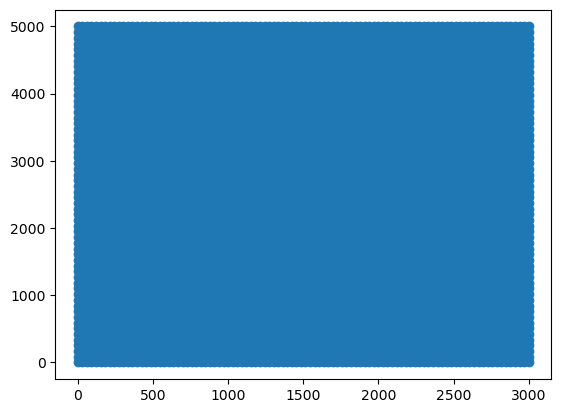

In [23]:
plt.scatter(coordinates[0],coordinates[1])

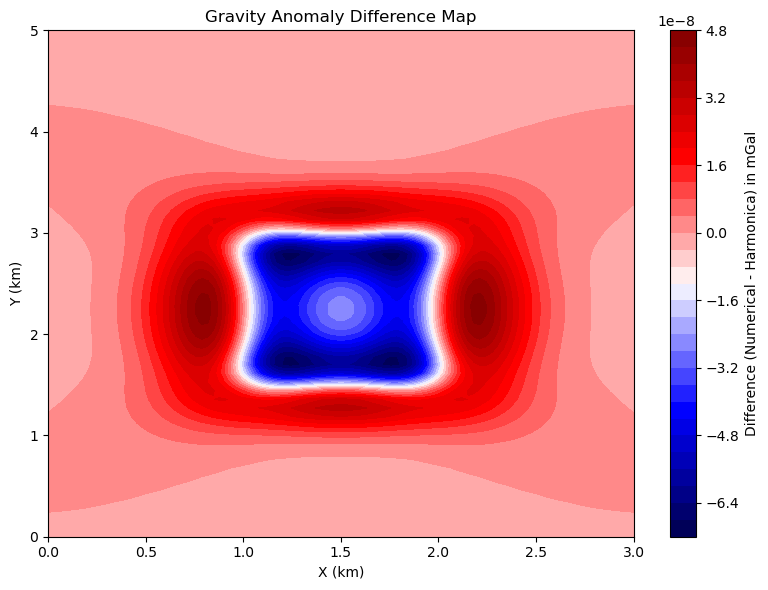

Max error (mGal): 6.978476818630952e-08
Mean error (mGal): 9.454371548793066e-09


In [4]:
# Reshape Harmonica result to 2D for comparison
g_zhm_reshaped = g_zhm.reshape((60, 100))

# Compute difference
diff = gz_mgal - g_zhm_reshaped

# Plot difference
plt.figure(figsize=(8, 6))
plt.contourf(Xobs / 1000, Yobs / 1000, diff, levels=30, cmap='seismic')
plt.colorbar(label="Difference (Numerical - Harmonica) in mGal")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("Gravity Anomaly Difference Map")
plt.tight_layout()
plt.show()

# Print error stats
print("Max error (mGal):", np.max(np.abs(diff)))
print("Mean error (mGal):", np.mean(np.abs(diff)))


# FOR FIVE PRISMATIC BODIES 

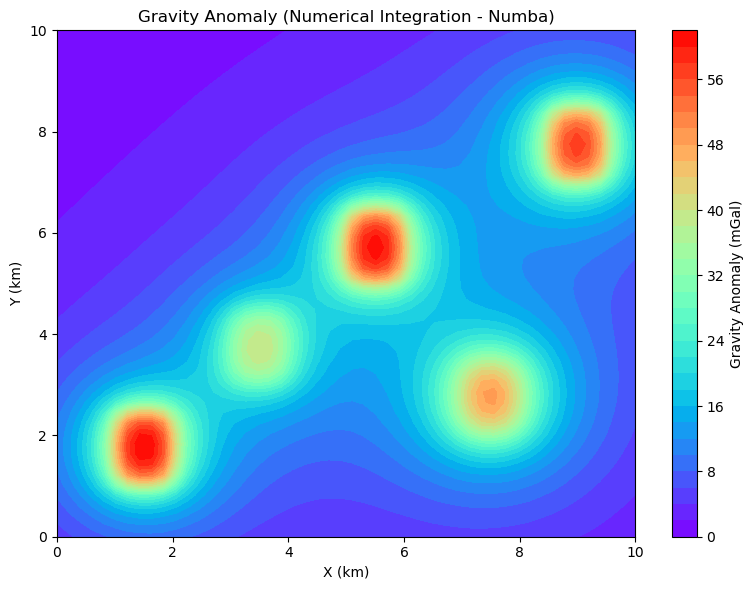

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import verde as vd
from numba import njit

# Grid setup (coarser voxel resolution for efficiency)
dx = dy = dz = 20
nx, ny, nz = int(10000/dx), int(10000/dy), int(4000/dz)

x = (np.arange(nx) + 0.5) * dx
y = (np.arange(ny) + 0.5) * dy
z = (np.arange(nz) + 0.5) * dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Density model
density = np.zeros((nx, ny, nz), dtype=float)

# Prism definitions (exactly matched)

prisms = [
    [1000, 2000, 1000, 2500, 100, 2500, 2670],  # Prism 1
    [3000, 4000, 3000, 4500, 202, 2000, 2670],  # Prism 2
    [5000, 6000, 5000, 6500, 120, 1900, 2670],  # Prism 3
    [7000, 8000, 2000, 3500, 300, 3500, 2670],  # Prism 4
    [8500, 9500, 7000, 8500, 100, 4000, 2670]   # Prism 5
]
for prism in prisms:
    xmin, xmax, ymin, ymax, zmin, zmax, rho = prism
    mask = (
        (X >= xmin) & (X <= xmax) &
        (Y >= ymin) & (Y <= ymax) &
        (Z >= zmin) & (Z <= zmax)
    )
    density[mask] = rho

# Observation grid (matching numerical code)
region = (0, 10000, 0, 10000)
obs_nx, obs_ny = 50, 50  # Same resolution as numerical integration
shape = (obs_nx, obs_ny)
obs_coords = vd.grid_coordinates(region=region, shape=shape, extra_coords=0)
obs_x, obs_y, obs_z = obs_coords
Xobs, Yobs, Zobs = obs_x.reshape(shape), obs_y.reshape(shape), obs_z.reshape(shape)

# Numba-accelerated calculation
G = 6.67430e-11
Xc, Yc, Zc = np.meshgrid(x, y, z, indexing='ij')

@njit(parallel=True)
def compute_gravity(Xobs, Yobs, Zobs, Xc, Yc, Zc, density, dx, dy, dz, G):
    obs_nx, obs_ny = Xobs.shape
    gz = np.zeros((obs_nx, obs_ny))
    for i in range(obs_nx):
        for j in range(obs_ny):
            rx = Xobs[i, j] - Xc
            ry = Yobs[i, j] - Yc
            rz = Zobs[i, j] - Zc
            r2 = rx**2 + ry**2 + rz**2 + 1e-12
            gz[i, j] = np.sum(G * density * rz / (r2**1.5) * dx * dy * dz)
    return gz

gz_num = compute_gravity(Xobs, Yobs, Zobs, Xc, Yc, Zc, density, dx, dy, dz, G)

# mGal conversion and plotting
gz_num_mgal = -gz_num * 1e5
plt.figure(figsize=(8, 6))
plt.contourf(Xobs/1000, Yobs/1000, gz_num_mgal, levels=30, cmap='rainbow')
plt.colorbar(label="Gravity Anomaly (mGal)")
plt.xlabel("X (km)")
plt.ylabel("Y (km)")
plt.title("Gravity Anomaly (Numerical Integration - Numba)")
plt.tight_layout()
plt.show()


# FOR THREE UNSYMMETRICAL BODIES

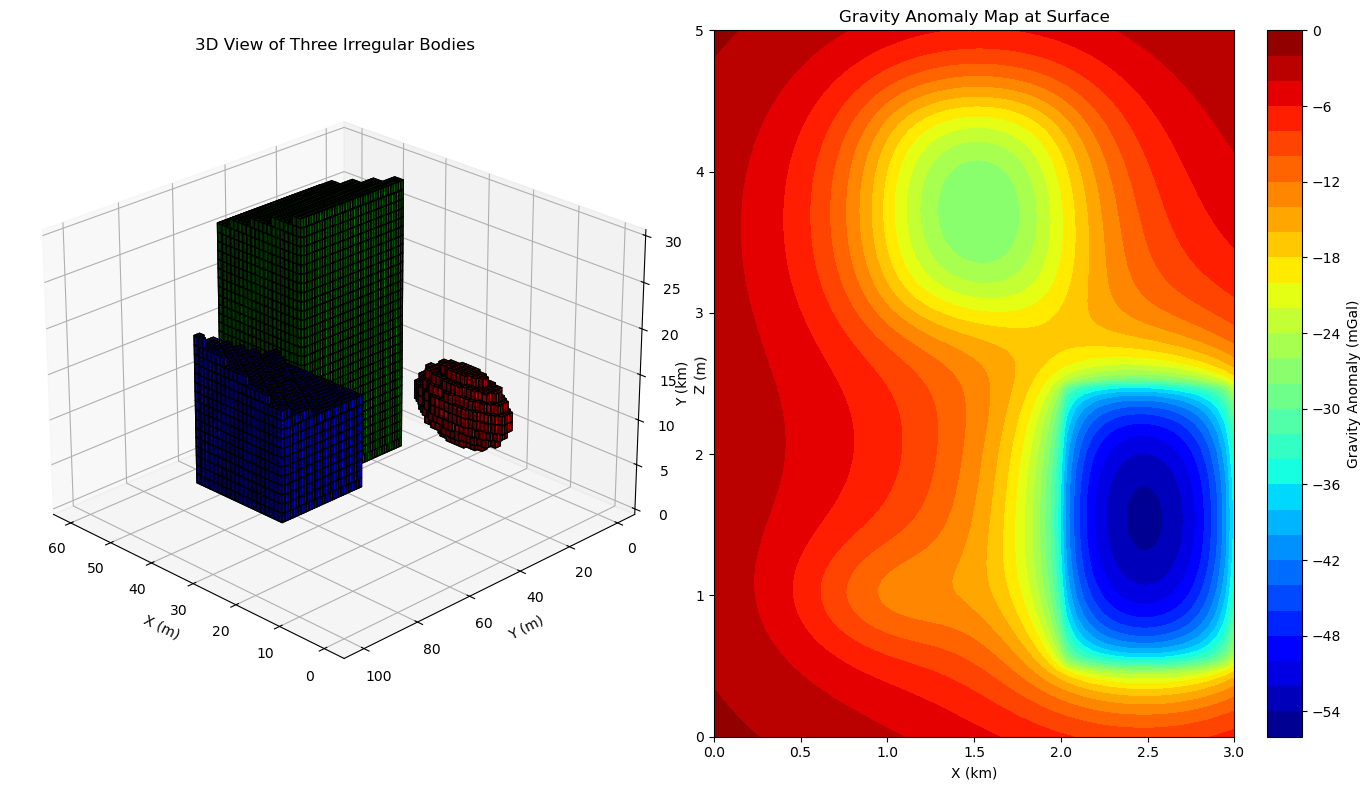

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# Grid setup (EXPANDED Y-DOMAIN to fit Body 3)
nx, ny, nz = 60, 100, 30
dx = dy = dz = 50  # in meters

x = (np.arange(nx) + 0.5) * dx
y = (np.arange(ny) + 0.5) * dy
z = (np.arange(nz) + 0.5) * dz
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# -----------------------------
# Initialize labels and density model
labels = np.zeros((nx, ny, nz), dtype=int)
density = np.zeros_like(labels, dtype=float)

# ---- Body 1: Ellipsoid ----
xc1, yc1, zc1 = 1000, 1000, 500
a1, b1, c1 = 500, 300, 200
rho1 = 2670
ellipsoid_mask = ((X - xc1)**2 / a1**2 + (Y - yc1)**2 / b1**2 + (Z - zc1)**2 / c1**2) <= 1
labels[ellipsoid_mask] = 1
density[ellipsoid_mask] = rho1

# ---- Body 2: Tilted Wedge ----
rho2 = 2300
wedge_mask = (
    (X > 2000) & (X < 3500) &
    (Y > 500) & (Y < 2500) &
    (Z < (1500 - (X - 2000) / 5))
)
labels[wedge_mask] = 2
density[wedge_mask] = rho2

# ---- Body 3: Bent Block ----
rho3 = 3000
z_bend = 1000 + 200 * np.sin((X + Y) * np.pi / 3000)
bent_block_mask = (
    (X > 1000) & (X < 2000) &
    (Y > 3000) & (Y < 4500) &
    (Z > 300) & (Z < z_bend)
)
labels[bent_block_mask] = 3
density[bent_block_mask] = rho3

# -----------------------------
# Gravity forward modeling (Finite Difference)
G = 6.67430e-11  # gravitational constant

# Observation grid at surface
obs_x = np.linspace(0, nx * dx, nx)
obs_y = np.linspace(0, ny * dy, ny)
Xobs, Yobs = np.meshgrid(obs_x, obs_y, indexing='ij')
Zobs = np.zeros_like(Xobs)  # surface observations

# Voxel centers
x_centers = x
y_centers = y
z_centers = z
Xc, Yc, Zc = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

# Compute gravity anomaly gz at surface
gz = np.zeros_like(Xobs)
for i in range(nx):
    for j in range(ny):
        rx = Xobs[i, j] - Xc
        ry = Yobs[i, j] - Yc
        rz = Zobs[i, j] - Zc
        r2 = rx**2 + ry**2 + rz**2 + 1e-12
        gz[i, j] = np.sum(G * density * rz / (r2**1.5) * dx * dy * dz)

# Scale to mGal
gz = gz*1e5

# -----------------------------
# Plot 1: 3D Voxel View of the Bodies
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(121, projection='3d')

filled = labels > 0
colors = np.empty_like(labels, dtype=object)
colors[labels == 1] = 'red'
colors[labels == 2] = 'green'
colors[labels == 3] = 'blue'

ax.voxels(filled, facecolors=colors, edgecolor='k', alpha=0.8)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Z (m)")
ax.set_title("3D View of Three Irregular Bodies")
ax.view_init(elev=25, azim=135)

# -----------------------------
# Plot 2: Gravity Anomaly Map
ax2 = fig.add_subplot(122)
c = ax2.contourf(Xobs / 1000, Yobs / 1000, gz, 30, cmap='jet')
plt.colorbar(c, ax=ax2, label="Gravity Anomaly (mGal)")
ax2.set_xlabel("X (km)")
ax2.set_ylabel("Y (km)")
ax2.set_title("Gravity Anomaly Map at Surface")

plt.tight_layout()
plt.show()